## Predicting possible Stock Hypes using Sentiment Analysis of News Papers and Web Forums
### A Project for the Course Python for Finance II at the University of Vienna 

__Authors:__
Atif Gangar, Jasmine Cerno, Loris Sultano

#### Introduction

Stock market prices and returns for certain sectors are nowadays quite volatile. This volatility is due in certain cases to extreme optimistic expectations by investors, which are itself often the product of a culture of believe in these sectors, fuelled by the media and investors themselves. The result are steep increases in stocks such as GamesStop, Tesla or some cryptocurrencies.

We propose, that the information contained in newspapers and web forums could possible be used to predict such steep increases in prices, which we will call hypes, for a short to medium time span, such as one month to three months. Using sentiment analysis of articles of the Guardian, a newspaper, and various reddit forums, we try to train a model, to predict such possible hypes.

#### Data 

As a first step in our data gathering, we need to decide on some stocks, which will be used for the training of the model. Since we try to predict price movements via the discussion about stocks in forums, we will use the ten most mentioned stocks in some reddit forums. As forums we will use the subreddits r/wallstreetbets, r/StockMarket, r/stocks and r/investing, since these are the biggest and most relevant subreddits regarding investing in and trading stocks.

To identify the ten most mentioned stocks, we look at 1000 posts from the 4 forums, as well as their comments, since most of the discussion happens in the comments to a post.


In [39]:
import praw
import re
from collections import Counter

In [40]:
reddit = praw.Reddit( # Create a Reddit instance
        client_id='KE1gFGfiFZPlqYgJOoMjEA', # client ID
        client_secret='HO6TcdYMufPB_tYk8yRiYdu4KQIxbw', # client secret
        user_agent='StockmarketPhytonII/1.0 by Alarming_Raccoon_816' # user agent
    )

In [ ]:
subreddits = ['StockMarket', 'stocks', 'wallstreetbets', 'investing']
posts = []

for subreddit in subreddits:
    for submission in reddit.subreddit(subreddit).top(limit=1000):  # Fetch top 1000 hot posts
        post_content = submission.title + ' ' + submission.selftext
        
        # Fetch top-level comments
        submission.comments.replace_more(limit=0)  # Expand all "load more comments"
        comments = ' '.join(comment.body for comment in submission.comments.list())
        
        # Combine post content and comments
        full_content = post_content + ' ' + comments
        posts.append(full_content)

In [95]:
# Define a list of known stock tickers
known_tickers = [
    'AAPL', 'AMZN', 'MSFT', 'GOOGL', 'META', 'NVDA', 'TSLA', 'INTC',
    'NFLX', 'GME', 'WMT', 'AMD', 'QCOM', 'ADBE', 'PYPL', 'SBUX',
    'EBAY', 'BIDU', 'BKNG', 'CRM', 'COST', 'CSCO', 'TXN', 'AVGO',
    'CHTR', 'INTU', 'AMGN', 'MDLZ', 'ISRG', 'TMUS', 'ADI', 'AMAT',
    'MU', 'BKNG', 'VRTX', 'MELI', 'JD', 'ATVI', 'KHC', 'ADSK',
    'LRCX', 'ILMN', 'REGN', 'FISV', 'ADP', 'NXPI', 'KLAC', 'MAR',
    'MRVL', 'IDXX', 'ROST', 'EA', 'XLNX', 'CTSH', 'BIIB', 'GILD',
    'EXC', 'LULU', 'SPLK', 'CSX', 'WBA', 'FAST', 'VRSN', 'CDNS',
    'SGEN', 'PCAR', 'SWKS', 'ALXN', 'MNST', 'MXIM', 'JD', 'SNPS',
    'ORLY', 'LBTYA', 'LBTYK', 'DLTR', 'NTES', 'PAYX', 'CHKP',
    'MCHP', 'VRSK', 'CTAS', 'TSCO', 'TTWO', 'CTXS', 'CDW', 'NDAQ',
    'NTAP', 'SIRI', 'VOD', 'ASML', 'KDP', 'WDAY', 'ROKU', 'XEL',
    'HOLX', 'ALGN', 'PDD', 'VFC', 'TRIP', 'CHKP', 'CERN', 'SBAC',
    'ANSS', 'PEP', 'MDT'
]

# Compile a regex pattern to match tickers
ticker_pattern = re.compile(r'\b(' + '|'.join(known_tickers) + r')\b')

# Count occurrences of each ticker
ticker_counts = Counter()

for post in posts:
    matches = ticker_pattern.findall(post)
    ticker_counts.update(matches)

# Get the ten most common tickers
most_common_tickers = ticker_counts.most_common(10)

# Display the results
for ticker, count in most_common_tickers:
    print(f"{ticker}: {count} mentions")

NVDA: 2108 mentions
AMD: 1598 mentions
INTC: 679 mentions
MSFT: 657 mentions
TSLA: 461 mentions
AAPL: 366 mentions
AMZN: 336 mentions
META: 315 mentions
GOOGL: 144 mentions
AVGO: 137 mentions


 
After identifying the ten most mentioned stocks, we continue using just these ten stocks. We limit ourselves to only ten stocks, due to the computational capabilities of our machines. So that training the models will be possible in reasonable time and also so that we have enough time to troubleshoot possible error encounter.

As a time span for which we will get our data, we will just use everything we can get since 1.2.2012, since then r/wallstreetbets was founded.


__Stocks and Variable indicating a Hype__


To identify a possible hype that leads to a steep increase in a stocks price, we simply just define a hype as 10% or more increase price over a timespan of one month. To capture this we just create a binary variable indicating, whether this happened or not over 20 days, since we assume for simplicity, that a month has 20 trading days.

In [4]:
import pandas as pd
from datetime import datetime
import yfinance as yf
import numpy as np

In [42]:
tickers = [
    'NVDA', 'AMD', 'INTC', 'MSFT', 'TSLA',
    'AAPL', 'AMZN', 'META', 'GOOGL', 'AVGO'
]

start_date = '2012-02-01' # Start date for fetching stock data

combined_data = pd.DataFrame() # Initialize an empty DataFrame to hold the combined data

for ticker in tickers: # Loop through each stock ticker
    stock = yf.Ticker(ticker) # Create a Ticker object for the stock
    stock_data = stock.history(start=start_date) # Fetch historical stock data

    stock_data = stock_data[['Close']] # Keep only the 'Close' column
    stock_data.rename(columns={'Close': ticker}, inplace=True) # Rename the 'Close' column to the stock ticker
    
    stock_data[f'{ticker}_20d_pct_change'] = stock_data[ticker].pct_change(periods=20) * 100 # Calculate the 20-day percentage change
    
    stock_data[f'{ticker}_hype'] = np.where(stock_data[f'{ticker}_20d_pct_change'] >= 10, 1, 0) # Create a binary variable for hype (1 if 20-day percentage change is >= 10%, 0 otherwise)

    stock_data[f'{ticker}_hype_next_month'] = stock_data[f'{ticker}_hype'].shift(-20)  # Shift the binary variable 20 days into the past

    if combined_data.empty: # If the combined DataFrame is empty, set it to the current stock data
        combined_data = stock_data 
    else: # Otherwise, join the current stock data to the combined DataFrame
        combined_data = combined_data.join(stock_data, how='outer') # Join the current stock data to the combined DataFrame

combined_data.reset_index(inplace=True) # Reset the index of the combined DataFrame

combined_data.to_csv('stock_data.csv', index=False) # Save the combined stock data to a CSV file
print("Combined stock data saved to stock_data.csv") # Print a message to indicate that the data has been saved

Combined stock data saved to stock_data.csv


__Guardian__

To get relevant articles from the Guardian, we search all articles since the beginning of 2012 for the names of the companies of the stocks as well for the keywords _stocks_ or _economy_, to capture also overall economic news and not just specific news to our chosen stocks in our sentiment analysis.

In [43]:
import requests

In [44]:
def get_articles(api_key, query, cutoff_date, page_size=200): # function to get articles from the Guardian API
    all_articles = [] # list to store all articles
    page = 1 # page number to start with
    cutoff_date = datetime.strptime(cutoff_date, '%Y-%m-%d') # parse the cutoff date
    while True: # loop to retrieve all articles
        url = f"https://content.guardianapis.com/search" # API endpoint
        params = { # parameters to pass to the API
            'api-key': api_key, # API key
            'q': query, # query to search for
            'page-size': page_size, # number of articles per page
            'page': page, # page number
            'show-fields': 'headline,trailText,bodyText', # fields to show in the response
            'order-by': 'newest' # order articles by newest
        }
        response = requests.get(url, params=params) # send a GET request to the API
        data = response.json() # parse the JSON response

        if 'response' not in data or 'results' not in data['response']: # check if the response is malformed
            print("No more articles found or API response is malformed.") # print a message
            break # break the loop

        articles = data['response']['results'] # get the articles from the response
        for article in articles: # loop through the articles
            if article.get('type') == 'article':  # check if the type is 'article'
                pub_date = datetime.strptime(article['webPublicationDate'][:10], '%Y-%m-%d') # parse the publication date
                if pub_date <= cutoff_date: # check if the publication date is earlier than or equal to the cutoff date
                    print("Reached articles older than cutoff date.")
                    return all_articles # return the articles collected so far
                all_articles.append(article) # add the article to the list

        if len(articles) < page_size: # check if the number of articles is less than the page size
            break # break the loop

        page += 1 # increment the page number

    return all_articles # return all articles

def main_guardian(api_key): # main function to run the program
    relevant_tags_query = '(stocks OR economy OR Nvidia OR AMD OR Intel OR Microsoft OR Tesla OR Apple OR Amazon OR Meta OR Facebook OR Alphabet OR Google OR Broadcom)'
# query to search for relevant tags
    cutoff_date = '2012-02-01' # specify the cutoff date
    
    articles = get_articles(api_key, relevant_tags_query, cutoff_date, page_size=200) # get the articles
    print(f"Retrieved {len(articles)} articles with query '{relevant_tags_query}' from the Guardian.") # print the number of articles

    articles_data = [] # list to store the articles data
    for article in articles: # loop through the articles
        if 'fields' in article: # check if the article has fields
            articles_data.append({ # add the article data to the list
                'webPublicationDate': article['webPublicationDate'], # publication date
                'headline': article['fields'].get('headline', ''), # headline
                'trailText': article['fields'].get('trailText', ''), # trail text
                'bodyText': article['fields'].get('bodyText', '') # body text
            })

    df = pd.DataFrame(articles_data) # create a DataFrame from the articles data
    df.to_csv('guardian_articles.csv', index=False) # save the DataFrame to a CSV file
    print("Articles saved to guardian_business_articles_with_tags.csv") # print a message

In [45]:
api_key = 'b425e693-8264-421f-a5fa-c6b79c603e58' # API key

main_guardian(api_key) # run the program for the Guardian

No more articles found or API response is malformed.
Retrieved 34198 articles with query '(stocks OR economy OR Nvidia OR AMD OR Intel OR Microsoft OR Tesla OR Apple OR Amazon OR Meta OR Facebook OR Alphabet OR Google OR Broadcom)' from the Guardian.
Articles saved to guardian_business_articles_with_tags.csv


__Reddit__

We also do the same for the 4 subreddits, with the only change, that we also search for the tickers of the stocks, since stocks are often called only by their tickers in the discussions on reddit and not by their companies full names.

In [46]:
def get_reddit_posts(client_id, client_secret, user_agent, subreddits, keywords, cutoff_date): # function to get Reddit posts
    
    all_posts = [] # list to store all posts
    cutoff_date = datetime.strptime(cutoff_date, '%Y-%m-%d') # parse the cutoff date

    for subreddit in subreddits: # loop through the subreddits
        subreddit_instance = reddit.subreddit(subreddit) # get the subreddit instance
        for submission in subreddit_instance.new(limit=None): # loop through the new submissions
            post_date = datetime.fromtimestamp(submission.created_utc) # parse the post date
            if post_date <= cutoff_date: # check if the post date is earlier than or equal to the cutoff date
                print(f"Reached posts older than cutoff date in subreddit {subreddit}.") # print a message
                break
            
            # Check if the submission title or body contains any of the keywords
            if any(keyword.lower() in submission.title.lower() or keyword.lower() in submission.selftext.lower() for keyword in keywords):
                comments = [] # list to store comments
                submission.comments.replace_more(limit=0) # replace the 'MoreComments' objects
                for comment in submission.comments.list(): # loop through the comments
                    comments.append(comment.body) # add the comment to the list
                
                all_posts.append({ # add the post data to the list
                    'created_utc': post_date, # post date
                    'title': submission.title, # post title
                    'selftext': submission.selftext, # post body
                    'comments': ' || '.join(comments) # comments
                })
    
    return all_posts # return all posts

def main_reddit(): # main function to run the program
    client_id = 'your_client_id' # client ID
    client_secret = 'your_client_secret' # client secret
    user_agent = 'your_user_agent' # user agent
    subreddits = ['StockMarket', 'stocks', 'wallstreetbets', 'investing'] # list of subreddits to scrape
    keywords = [
    'stocks', 'economy',
    'Nvidia', 'NVDA',
    'AMD', 'AMD',
    'Intel', 'INTC',
    'Microsoft', 'MSFT',
    'Tesla', 'TSLA',
    'Apple', 'AAPL',
    'Amazon', 'AMZN',
    'Meta', 'META',
    'Alphabet', 'GOOGL',
    'Broadcom', 'AVGO'
] # keywords to search for
    cutoff_date = '2012-02-01' # specify the cutoff date
    
    # Get Reddit posts
    posts = get_reddit_posts(client_id, client_secret, user_agent, subreddits, keywords, cutoff_date)
    print(f"Retrieved {len(posts)} posts from Reddit.") # print the number of posts

    # Save the posts to a CSV file
    df = pd.DataFrame(posts)
    df.to_csv('reddit_posts.csv', index=False)
    print("Posts saved to reddit_posts.csv")

In [47]:
main_reddit() # run the program for Reddit

Retrieved 1495 posts from Reddit.
Posts saved to reddit_posts.csv


Finally we will combine both the articles from the Guardian and the post from reddit to one single data frame, so that we can create a bag of words model out of it. For this we will combine them according to the date, so we will drop possible information contained in the time of day at which a reddit post is posted. Because we are interesting in detecting hypes over a timeframe of roughly a month, we believe this information is not relevant, since at which time of the day a post is posted, could maybe indicate price movements on the next day, but not the next month.

In [48]:
guardian_data = pd.read_csv('guardian_articles.csv') # Load the Guardian articles data
guardian_data['webPublicationDate'] = pd.to_datetime(guardian_data['webPublicationDate']).dt.date # Convert the publication date to date format

reddit_data = pd.read_csv('reddit_posts.csv') # Load the Reddit posts data
reddit_data['created_utc'] = pd.to_datetime(reddit_data['created_utc']).dt.date # Convert the post date to date format

stock_data = pd.read_csv('stock_data.csv') # Load the stock data
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date # Convert the date to date format

def concatenate_text(series): # function to concatenate text in a Series
    return ' '.join(series.dropna().astype(str)) # concatenate the text values

guardian_agg = guardian_data.groupby('webPublicationDate').agg({ # Aggregate the Guardian data by publication date
    'headline': concatenate_text, # concatenate the headlines
    'trailText': concatenate_text, # concatenate the trail texts
    'bodyText': concatenate_text # concatenate the body texts
}).rename(columns={ # rename the columns
    'headline': 'guardian_headlines', # headlines
    'trailText': 'guardian_trailTexts', # trail texts
    'bodyText': 'guardian_bodyTexts' # body texts
}).reset_index() 

reddit_agg = reddit_data.groupby('created_utc').agg({ # Aggregate the Reddit data by post date
    'title': concatenate_text, # concatenate the titles
    'selftext': concatenate_text, # concatenate the selftexts
    'comments': concatenate_text # concatenate the comments
}).rename(columns={ # rename the columns
    'title': 'reddit_titles', # titles
    'selftext': 'reddit_selftexts', # selftexts
    'comments': 'reddit_comments' # comments
}).reset_index()

# Merge the aggregated Guardian and Reddit data with the stock data
combined_data = stock_data.merge(guardian_agg, left_on='Date', right_on='webPublicationDate', how='left')
combined_data = combined_data.merge(reddit_agg, left_on='Date', right_on='created_utc', how='left')

# Fill NaN values with empty strings for text fields and 0 for numeric fields
text_fields = ['guardian_headlines', 'guardian_trailTexts', 'guardian_bodyTexts', 'reddit_titles', 'reddit_selftexts', 'reddit_comments']
combined_data[text_fields] = combined_data[text_fields].fillna('')

combined_data['combined_text'] = ( # Combine all text fields into a single field
    combined_data['guardian_headlines'] + ' ' + 
    combined_data['guardian_trailTexts'] + ' ' +
    combined_data['guardian_bodyTexts'] + ' ' +
    combined_data['reddit_titles'] + ' ' +
    combined_data['reddit_selftexts'] + ' ' +
    combined_data['reddit_comments']
)

# Create the aggregated text column using the last 20 days
combined_data['aggregated_text'] = ''
window_size = 20

for i in range(len(combined_data)):
    start_idx = max(0, i - window_size + 1)
    # Aggregate the text from the last 20 days (or fewer if at the start)
    aggregated_text = ' '.join(combined_data.iloc[start_idx:i+1]['combined_text'])
    combined_data.at[i, 'aggregated_text'] = aggregated_text

# Drop the redundant columns
combined_data.drop(columns=['webPublicationDate', 'created_utc', 'guardian_headlines', 'guardian_trailTexts', 'guardian_bodyTexts', 'reddit_titles', 'reddit_selftexts', 'reddit_comments'], inplace=True)

# Drop rows with NaN in target variables
target_columns = [
    'NVDA_hype_next_month',
    'AMD_hype_next_month',
    'INTC_hype_next_month',
    'MSFT_hype_next_month',
    'TSLA_hype_next_month',
    'AAPL_hype_next_month',
    'AMZN_hype_next_month',
    'META_hype_next_month',
    'GOOGL_hype_next_month',
    'AVGO_hype_next_month']
combined_data = combined_data.dropna(subset=target_columns)

# Save the combined data to a CSV file
combined_data.to_csv('combined_data.csv', index=False)
print("Combined data saved to combined_data.csv")

Combined data saved to combined_data.csv


#### Models

__Bag of Words Model__

To perform sentiment analysis using the collected data, we first need to fit and transform the text data. For this we use the _TfidVectorizer_ , because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words.

In addition to creating the bag of words model, we also have a quick look on distribution of our binary target variables, since one has to expect imbalances between these two targets, since hypes might not occur so often.

When visualising the target variable, it is immediately clear, that we deal with a great imbalance between the two states. Non hypes are much more frequent for all stocks we are looking at. This is something we have to consider and address in the specification of our models, as well at the interpretation of their performance.

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [50]:
df = pd.read_csv('combined_data.csv') # read the merged data from the CSV file

In [51]:
df = df.sort_values('Date') # sort the data by publication date
    
split_idx = int(0.8 * len(df)) # 80-20 train-test split
train_df = df[:split_idx] # training data
test_df = df[split_idx:] # test data

vectorizer = TfidfVectorizer(stop_words='english') # initialize the TF-IDF vectorizer
combined_train = vectorizer.fit_transform(train_df['combined_text']) # fit and transform the training text data
combined_test = vectorizer.transform(test_df['combined_text']) # transform the test text data

hype20_train = np.sign(train_df[[
    'NVDA_hype_next_month',
    'AMD_hype_next_month',
    'INTC_hype_next_month',
    'MSFT_hype_next_month',
    'TSLA_hype_next_month',
    'AAPL_hype_next_month',
    'AMZN_hype_next_month',
    'META_hype_next_month',
    'GOOGL_hype_next_month',
    'AVGO_hype_next_month'
]]) # convert the returns to binary labels
hype20_test = np.sign(test_df[[
    'NVDA_hype_next_month',
    'AMD_hype_next_month',
    'INTC_hype_next_month',
    'MSFT_hype_next_month',
    'TSLA_hype_next_month',
    'AAPL_hype_next_month',
    'AMZN_hype_next_month',
    'META_hype_next_month',
    'GOOGL_hype_next_month',
    'AVGO_hype_next_month'
]]) # convert the returns to binary labels


In [52]:
import matplotlib.pyplot as plt

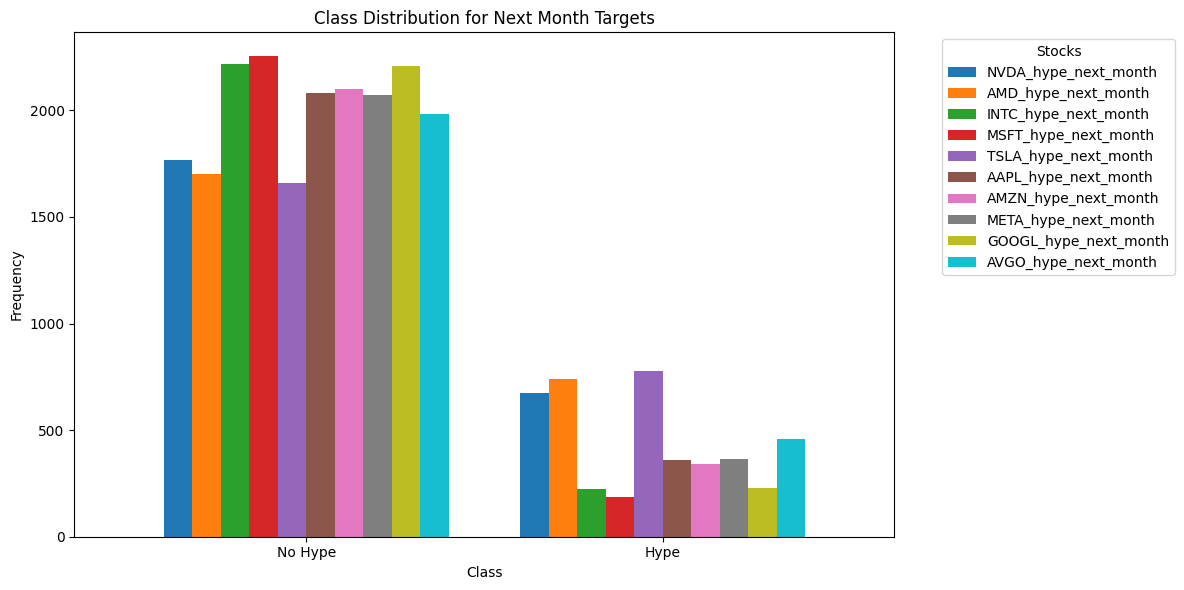

In [53]:
# Prepare data for next month targets
next_month_data = []
next_month_labels = []
next_month_imbalance_ratios = []

for column in train_df.columns:
    if 'next_month' in column:
        class_counts = train_df[column].value_counts().sort_index()
        imbalance_ratio = class_counts.min() / class_counts.max()
        next_month_data.append(class_counts)
        next_month_labels.append(column)
        next_month_imbalance_ratios.append(imbalance_ratio)

# Function to plot class distributions for each set of targets with imbalance ratios
def plot_class_distributions(data, labels, imbalance_ratios, title):
    num_targets = len(data)
    num_classes = 2  # Assuming binary classification (0 and 1)
    
    # Create a DataFrame for plotting
    df_plot = pd.DataFrame(index=range(num_classes), columns=labels)
    for i, counts in enumerate(data):
        df_plot[labels[i]] = counts
    
    # Plot
    ax = df_plot.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(ticks=[0, 1], labels=['No Hype', 'Hype'], rotation=0)
    
    plt.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot combined class distribution for next month targets
plot_class_distributions(next_month_data, next_month_labels, next_month_imbalance_ratios, 'Class Distribution for Next Month Targets')

__Random Forest__

Our first model we try to train is a simple multioutput random forest classifier. To address the imbalance we make sure to set the _classweight_ attribute of the function to _balanced_.

Since sentiment analysis in finance involves dealing with noisy data where outliers and conflicting sentiments can occur frequently, using a random forest classifier can make sense, because it is an ensemble method that aggregates predictions from multiple decision trees, which helps in smoothing out noise and reducing the impact of outliers.

In [54]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [55]:
# Define target columns for next month
next_month_targets = [
    'NVDA_hype_next_month',
    'AMD_hype_next_month',
    'INTC_hype_next_month',
    'MSFT_hype_next_month',
    'TSLA_hype_next_month',
    'AAPL_hype_next_month',
    'AMZN_hype_next_month',
    'META_hype_next_month',
    'GOOGL_hype_next_month',
    'AVGO_hype_next_month'
]

def train_random_forest(X_train, y_train, X_test, y_test):
    # Use next month targets directly
    target_columns = next_month_targets
    
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')  # Initialize the Random Forest classifier
    multi_target_rf = MultiOutputClassifier(rf, n_jobs=-1)  # MultiOutputClassifier with Random Forest as base
    
    # Use GridSearchCV to find the best parameters
    grid_search = GridSearchCV(estimator=multi_target_rf, param_grid=param_grid, cv=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)  # Fit the GridSearchCV
    
    best_rf = grid_search.best_estimator_  # Best Random Forest model
    best_rf.fit(X_train, y_train)  # Fit the best Random Forest model
    
    # Calculate the training and test accuracy
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_predictions)  # Overall training accuracy
    test_accuracy = accuracy_score(y_test, test_predictions)  # Overall test accuracy
    
    print(f"Best parameters found: {grid_search.best_params_}")
    
    # Calculate overall metrics
    overall_precision_train = precision_score(y_train, train_predictions, average='macro', zero_division=0)
    overall_recall_train = recall_score(y_train, train_predictions, average='macro', zero_division=0)
    overall_f1_train = f1_score(y_train, train_predictions, average='macro', zero_division=0)

    overall_precision_test = precision_score(y_test, test_predictions, average='macro', zero_division=0)
    overall_recall_test = recall_score(y_test, test_predictions, average='macro', zero_division=0)
    overall_f1_test = f1_score(y_test, test_predictions, average='macro', zero_division=0)
    
    # Create DataFrame for overall metrics
    overall_metrics = pd.DataFrame({
        'Dataset': ['Training', 'Test'],
        'Accuracy': [train_accuracy, test_accuracy],
        'Precision': [overall_precision_train, overall_precision_test],
        'Recall': [overall_recall_train, overall_recall_test],
        'F1 Score': [overall_f1_train, overall_f1_test]
    })
    
    # Create DataFrame for per-stock metrics
    stock_metrics = []
    for i, column in enumerate(target_columns):
        stock_train_accuracy = accuracy_score(y_train.iloc[:, i], train_predictions[:, i])
        stock_test_accuracy = accuracy_score(y_test.iloc[:, i], test_predictions[:, i])
        stock_precision = precision_score(y_test.iloc[:, i], test_predictions[:, i], zero_division=0)
        stock_recall = recall_score(y_test.iloc[:, i], test_predictions[:, i], zero_division=0)
        stock_f1 = f1_score(y_test.iloc[:, i], test_predictions[:, i], zero_division=0)
        
        stock_metrics.append({
            'Stock': column,
            'Training Accuracy': stock_train_accuracy,
            'Test Accuracy': stock_test_accuracy,
            'Precision': stock_precision,
            'Recall': stock_recall,
            'F1 Score': stock_f1
        })
    
    stock_metrics_df = pd.DataFrame(stock_metrics)
    
    # Display the overall metrics
    print("\nOverall Metrics:")
    print(overall_metrics.to_string(index=False))
    
    # Display the per-stock metrics
    print("\nPer-Stock Metrics:")
    print(stock_metrics_df.to_string(index=False))

param_grid = {
    'estimator__n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
    'estimator__max_depth': [5, 10, 20, None]  # Maximum depth of the tree
}

In [56]:
train_random_forest(combined_train, hype20_train, combined_test, hype20_test) # train the Random Forest model    

Best parameters found: {'estimator__max_depth': 5, 'estimator__n_estimators': 200}

Overall Metrics:
 Dataset  Accuracy  Precision   Recall  F1 Score
Training  0.197131   0.626748 0.642031  0.495554
    Test  0.009820   0.161221 0.213130  0.116689

Per-Stock Metrics:
                Stock  Training Accuracy  Test Accuracy  Precision   Recall  F1 Score
 NVDA_hype_next_month           0.802459       0.423895   0.381779 0.724280  0.500000
  AMD_hype_next_month           0.508607       0.703764   0.833333 0.027027  0.052356
 INTC_hype_next_month           0.948361       0.841244   0.000000 0.000000  0.000000
 MSFT_hype_next_month           0.958197       0.891980   0.000000 0.000000  0.000000
 TSLA_hype_next_month           0.745492       0.271686   0.260000 0.993631  0.412153
 AAPL_hype_next_month           0.902869       0.561375   0.137097 0.386364  0.202381
 AMZN_hype_next_month           0.394262       0.823241   0.000000 0.000000  0.000000
 META_hype_next_month           0.400000    

Although some test accuracies, for instance Google, Microsoft and AMD are quite promising, when looking at the precision metric, it does not look that good any more. 

For most of the stocks the precision is 0, even if the test accuracy was quite high, like in the case of Google. This finding is most likely driven by the high imbalance, since the model predicts quite accurately, only because there are much lesser hypes than non hypes and it is not able to detect any hypes for Google. Looking at the graph above, we can see this also, since for Google, the imbalance is one of the greatest for the stocks.

An interesting case is AMD, since the test accuracy is quite good and precision too, the positive predictions are mostly correct, but recall is really low, indicating we miss many true positives.

__Gradient Boosting__

To furhter address the imbalance in the target variable, which most likely causes the really low precision, we try a gradient boosting via _XGBoost_. Since XGBoost allows for the use of weighted loss functions, it could help to counter the imbalance. Here we use for each stock their imbalance ratio as a weight, which should help to train the model better.

In [58]:
from xgboost import XGBClassifier

In [59]:
def calculate_scale_pos_weights(y_train):
    """
    Calculate the scale_pos_weight for each target based on the imbalance ratio.

    Parameters:
    y_train (DataFrame): Training labels for stock hype prediction.

    Returns:
    dict: A dictionary of scale_pos_weights for each target.
    """
    scale_pos_weights = {}
    for column in y_train.columns:
        class_counts = y_train[column].value_counts()
        # Avoid division by zero by setting a high weight if the minority class is missing
        if len(class_counts) < 2:
            scale_pos_weights[column] = 1.0
        else:
            scale_pos_weights[column] = class_counts[0] / class_counts[1] if class_counts[1] != 0 else class_counts[0]
    return scale_pos_weights

def train_multioutput_xgboost(combined_train, combined_test, hype_train, hype_test):
    """
    Train a MultiOutput XGBoost model for predicting stock hype.

    Parameters:
    combined_train (sparse matrix): TF-IDF transformed training text data.
    combined_test (sparse matrix): TF-IDF transformed test text data.
    hype_train (DataFrame): Training labels for stock hype prediction.
    hype_test (DataFrame): Test labels for stock hype prediction.

    Returns:
    None: Prints evaluation metrics for the model.
    """
    
    # Calculate scale_pos_weights based on the training data imbalance
    scale_pos_weights = calculate_scale_pos_weights(hype_train)

    # Initialize XGBoost classifiers for each target with corresponding weights
    xgb_clf = XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Wrap the classifiers with MultiOutputClassifier
    multi_output_xgb = MultiOutputClassifier(estimator=xgb_clf, n_jobs=-1)
    
    # Fit the model
    multi_output_xgb.fit(combined_train, hype_train)
    
    # Predict on the test set
    test_predictions = multi_output_xgb.predict(combined_test)
    
    # Store metrics for each target
    stock_metrics = []
    for i, column in enumerate(hype_test.columns):
        test_accuracy = accuracy_score(hype_test[column], test_predictions[:, i])
        test_f1 = f1_score(hype_test[column], test_predictions[:, i], zero_division=0)
        test_precision = precision_score(hype_test[column], test_predictions[:, i], zero_division=0)
        test_recall = recall_score(hype_test[column], test_predictions[:, i], zero_division=0)
        
        stock_metrics.append({
            'Stock': column,
            'Test Accuracy': test_accuracy,
            'Precision': test_precision,
            'Recall': test_recall,
            'F1 Score': test_f1
        })

    stock_metrics_df = pd.DataFrame(stock_metrics)

    # Calculate overall metrics for all targets combined
    overall_accuracy = accuracy_score(hype_test, test_predictions)
    overall_precision = precision_score(hype_test, test_predictions, average='macro', zero_division=0)
    overall_recall = recall_score(hype_test, test_predictions, average='macro', zero_division=0)
    overall_f1 = f1_score(hype_test, test_predictions, average='macro', zero_division=0)
    
    # Create DataFrame for overall metrics
    overall_metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [overall_accuracy, overall_precision, overall_recall, overall_f1]
    })

    # Display the overall metrics
    print("Overall Model Metrics:")
    print(overall_metrics.to_string(index=False))
    
    # Display the per-stock metrics
    print("\nIndividual Stock Metrics:")
    print(stock_metrics_df.to_string(index=False))



In [60]:
train_multioutput_xgboost(combined_train, combined_test, hype20_train, hype20_test)

/Users/lorissultano/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lorissultano/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lorissultano/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lorissultano/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

Overall Model Metrics:
   Metric    Score
 Accuracy 0.248773
Precision 0.135536
   Recall 0.034389
 F1 Score 0.047248

Individual Stock Metrics:
                Stock  Test Accuracy  Precision   Recall  F1 Score
 NVDA_hype_next_month       0.540098   0.288889 0.106996  0.156156
  AMD_hype_next_month       0.679214   0.296296 0.043243  0.075472
 INTC_hype_next_month       0.836334   0.200000 0.010309  0.019608
 MSFT_hype_next_month       0.891980   0.000000 0.000000  0.000000
 TSLA_hype_next_month       0.644845   0.236842 0.171975  0.199262
 AAPL_hype_next_month       0.854337   0.333333 0.011364  0.021978
 AMZN_hype_next_month       0.823241   0.000000 0.000000  0.000000
 META_hype_next_month       0.731588   0.000000 0.000000  0.000000
GOOGL_hype_next_month       0.869067   0.000000 0.000000  0.000000
 AVGO_hype_next_month       0.772504   0.000000 0.000000  0.000000


This model has an overall better test accuracy, but similar low precision and recall scores, still indicating that the accuracy is only due to the high imbalance. It seems to just happen to guess correct since most targets are non hypes.

__Balanced Random Forest__

As a last try we go back to a random forest model, but this time we bootstrap each sample by undersampling the majority class. By doing this, we try to create a balanced dataset for each tree in the forest, hoping the imbalance is addressed effectively.

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

In [66]:
# Define target columns for next month
next_month_targets = [
    'NVDA_hype_next_month',
    'AMD_hype_next_month',
    'INTC_hype_next_month',
    'MSFT_hype_next_month',
    'TSLA_hype_next_month',
    'AAPL_hype_next_month',
    'AMZN_hype_next_month',
    'META_hype_next_month',
    'GOOGL_hype_next_month',
    'AVGO_hype_next_month'
]

def train_balanced_random_forest(X_train, y_train, X_test, y_test):
    # Ensure input data is non-empty
    if X_train is None or y_train is None or X_test is None or y_test is None:
        print("One of the input datasets is None. Please check your data inputs.")
        return
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Use next month targets directly
    target_columns = next_month_targets

    # Define Random Forest with balanced sampling using RandomUnderSampler
    def create_balanced_rf_pipeline():
        rus = RandomUnderSampler()  # Under-sample the majority class
        rf = RandomForestClassifier(random_state=42)
        return Pipeline([('undersample', rus), ('classifier', rf)])

    # Create a MultiOutputClassifier with the balanced Random Forest pipeline
    multi_target_rf = MultiOutputClassifier(create_balanced_rf_pipeline(), n_jobs=-1)

    # Use GridSearchCV to find the best parameters
    grid_search = GridSearchCV(
        estimator=multi_target_rf,
        param_grid=param_grid,
        cv=2,
        scoring='accuracy'
    )
    
    print("Starting GridSearchCV fit...")
    grid_search.fit(X_train, y_train)  # Fit the GridSearchCV

    best_rf = grid_search.best_estimator_  # Best Random Forest model
    print("Best Random Forest model found.")
    
    best_rf.fit(X_train, y_train)  # Fit the best Random Forest model
    print("Model training complete.")

    # Calculate the training and test accuracy
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_predictions)  # Overall training accuracy
    test_accuracy = accuracy_score(y_test, test_predictions)  # Overall test accuracy

    print(f"Best parameters found: {grid_search.best_params_}")

    # Calculate overall metrics
    overall_precision_train = precision_score(y_train, train_predictions, average='macro', zero_division=0)
    overall_recall_train = recall_score(y_train, train_predictions, average='macro', zero_division=0)
    overall_f1_train = f1_score(y_train, train_predictions, average='macro', zero_division=0)

    overall_precision_test = precision_score(y_test, test_predictions, average='macro', zero_division=0)
    overall_recall_test = recall_score(y_test, test_predictions, average='macro', zero_division=0)
    overall_f1_test = f1_score(y_test, test_predictions, average='macro', zero_division=0)

    # Create DataFrame for overall metrics
    overall_metrics = pd.DataFrame({
        'Dataset': ['Training', 'Test'],
        'Accuracy': [train_accuracy, test_accuracy],
        'Precision': [overall_precision_train, overall_precision_test],
        'Recall': [overall_recall_train, overall_recall_test],
        'F1 Score': [overall_f1_train, overall_f1_test]
    })

    # Create DataFrame for per-stock metrics
    stock_metrics = []
    for i, column in enumerate(target_columns):
        stock_train_accuracy = accuracy_score(y_train.iloc[:, i], train_predictions[:, i])
        stock_test_accuracy = accuracy_score(y_test.iloc[:, i], test_predictions[:, i])
        stock_precision = precision_score(y_test.iloc[:, i], test_predictions[:, i], zero_division=0)
        stock_recall = recall_score(y_test.iloc[:, i], test_predictions[:, i], zero_division=0)
        stock_f1 = f1_score(y_test.iloc[:, i], test_predictions[:, i], zero_division=0)

        stock_metrics.append({
            'Stock': column,
            'Training Accuracy': stock_train_accuracy,
            'Test Accuracy': stock_test_accuracy,
            'Precision': stock_precision,
            'Recall': stock_recall,
            'F1 Score': stock_f1
        })

    stock_metrics_df = pd.DataFrame(stock_metrics)

    # Display the overall metrics
    print("\nOverall Metrics:")
    print(overall_metrics.to_string(index=False))

    # Display the per-stock metrics
    print("\nPer-Stock Metrics:")
    print(stock_metrics_df.to_string(index=False))

param_grid = {
    'estimator__classifier__n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
    'estimator__classifier__max_depth': [5, 10, 20, None]  # Maximum depth of the tree
}

In [67]:
train_balanced_random_forest(combined_train, hype20_train, combined_test, hype20_test)

X_train shape: (2440, 126975)
y_train shape: (2440, 10)
X_test shape: (611, 126975)
y_test shape: (611, 10)
Starting GridSearchCV fit...
Best Random Forest model found.
Model training complete.
Best parameters found: {'estimator__classifier__max_depth': 20, 'estimator__classifier__n_estimators': 100}

Overall Metrics:
 Dataset  Accuracy  Precision   Recall  F1 Score
Training  0.005328   0.277125 0.650829  0.343713
    Test  0.000000   0.224638 0.650772  0.268434

Per-Stock Metrics:
                Stock  Training Accuracy  Test Accuracy  Precision   Recall  F1 Score
 NVDA_hype_next_month           0.725410       0.418985   0.399281 0.913580  0.555695
  AMD_hype_next_month           0.468852       0.510638   0.284091 0.405405  0.334076
 INTC_hype_next_month           0.720082       0.173486   0.158863 0.979381  0.273381
 MSFT_hype_next_month           0.740984       0.134206   0.102916 0.909091  0.184900
 TSLA_hype_next_month           0.721311       0.296236   0.264249 0.974522  0.4157

Using this model, the test accuracies are now quite lower overall while the precision and recall is much higher overall, indicating, that the model is overall more correct when identifying a hype and also does not miss that many hypes as the previous models. Bootstrapping the samples seems to have worked to better the problem of imbalance. But the F1 score is still quite low.

#### Conclusion

In our analysis of multi-output classification models for predicting stock hype via sentiment analysis, we tested several approaches to tackle the challenges of class imbalance and noisy financial data. Our initial model, a random forest classifier, utilized ensemble averaging to manage noise. However, despite applying balanced class weights, the model struggled with class imbalance. While some stocks, like Google and Microsoft, showed high test accuracies, the precision was near zero, indicating that the model often predicted the dominant non-hype class without accurately identifying actual hype events.

To address this, we implemented gradient boosting with XGBoost, leveraging weighted loss functions to counter imbalance. Although test accuracy improved, the precision and recall remained low, suggesting that the model still missed many true hype events.
Our final approach was a balanced random forest, which undersampled the majority class to create a more balanced dataset. This improved precision and recall, indicating better hype detection. However, test accuracy decreased, and while F1 scores improved, further refinement is needed to balance precision and recall effectively.

Therefore we conclude that, given our data and modelling, we were not able to predict hypes of stocks using sentiment analysis.